In [21]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

<Axes: >

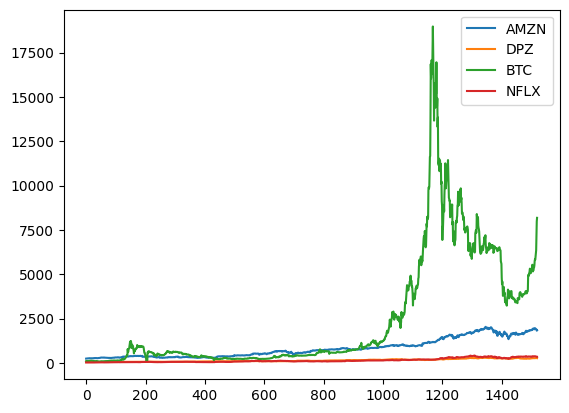

In [22]:
df = pd.read_csv('portfolio_data.csv')
df.plot()

<Axes: >

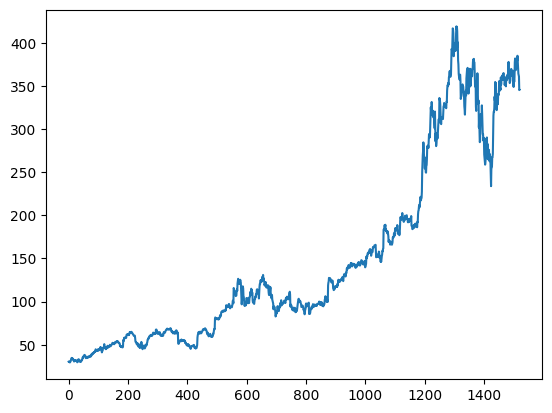

In [23]:
df_nflx = df['NFLX']
df_nflx.plot()

<Axes: >

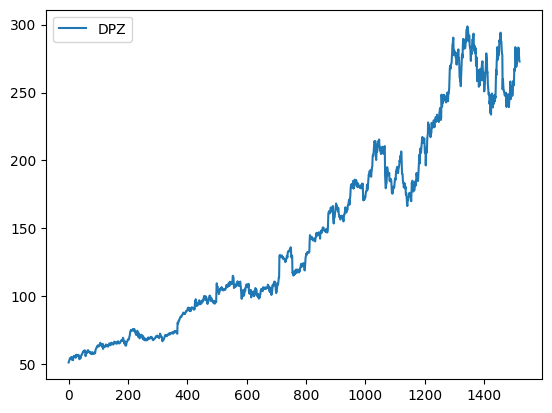

In [24]:
df_dpz = df[['DPZ']]
df_dpz.plot()

In [25]:
from sklearn.preprocessing import MinMaxScaler

def generate_sequences(data, seq_length, column_name='DPZ'):
    sequences = []
    targets = []

    values = data[column_name].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    values_scaled = scaler.fit_transform(values)

    for i in range(len(values_scaled) - seq_length):
        seq = values_scaled[i:i + seq_length]
        target = values_scaled[i + seq_length]

        sequences.append(seq)
        targets.append(target)

    sequences = np.array(sequences).reshape(-1, seq_length, 1)
    targets = np.array(targets).reshape(-1, 1)

    return sequences, targets, scaler

sequence_length = 30

X, y, scaler = generate_sequences(df_dpz, sequence_length)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X range: [{X.min():.3f}, {X.max():.3f}]")

X shape: (1490, 30, 1)
y shape: (1490, 1)
X range: [0.000, 1.000]


In [26]:
from sklearn.model_selection import train_test_split

test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

val_ratio = test_ratio / (1 - test_ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (894, 30, 1), Val: (298, 30, 1), Test: (298, 30, 1)


In [27]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [28]:
import torch.optim as optim
from GRU import *

input_dim = 1
output_dim = 1
hidden_dim = 64
layer_dim = 3
n_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'output_dim' : output_dim,
                'hidden_dim' : hidden_dim,
                'n_layers' : layer_dim,
                'dropout': 0.2
                }

model = StockGRU(**model_params)

loss_fn = torch.nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, n_epochs=n_epochs, n_features=input_dim)

predictions, values = opt.evaluate(test_loader=test_loader, batch_size=batch_size, n_features=input_dim)


[1/20] Training loss: 0.0122	 Validation loss: 0.0359
[2/20] Training loss: 0.0013	 Validation loss: 0.0007
[3/20] Training loss: 0.0004	 Validation loss: 0.0007
[4/20] Training loss: 0.0004	 Validation loss: 0.0009
[5/20] Training loss: 0.0004	 Validation loss: 0.0009
[6/20] Training loss: 0.0003	 Validation loss: 0.0007
[7/20] Training loss: 0.0003	 Validation loss: 0.0008
[8/20] Training loss: 0.0003	 Validation loss: 0.0009
[9/20] Training loss: 0.0003	 Validation loss: 0.0008
[10/20] Training loss: 0.0003	 Validation loss: 0.0012


Predictions shape: (298, 1)
Values shape: (298, 1)
Train values length: 1222
Test predictions length: 298
Total timeline length: 1520


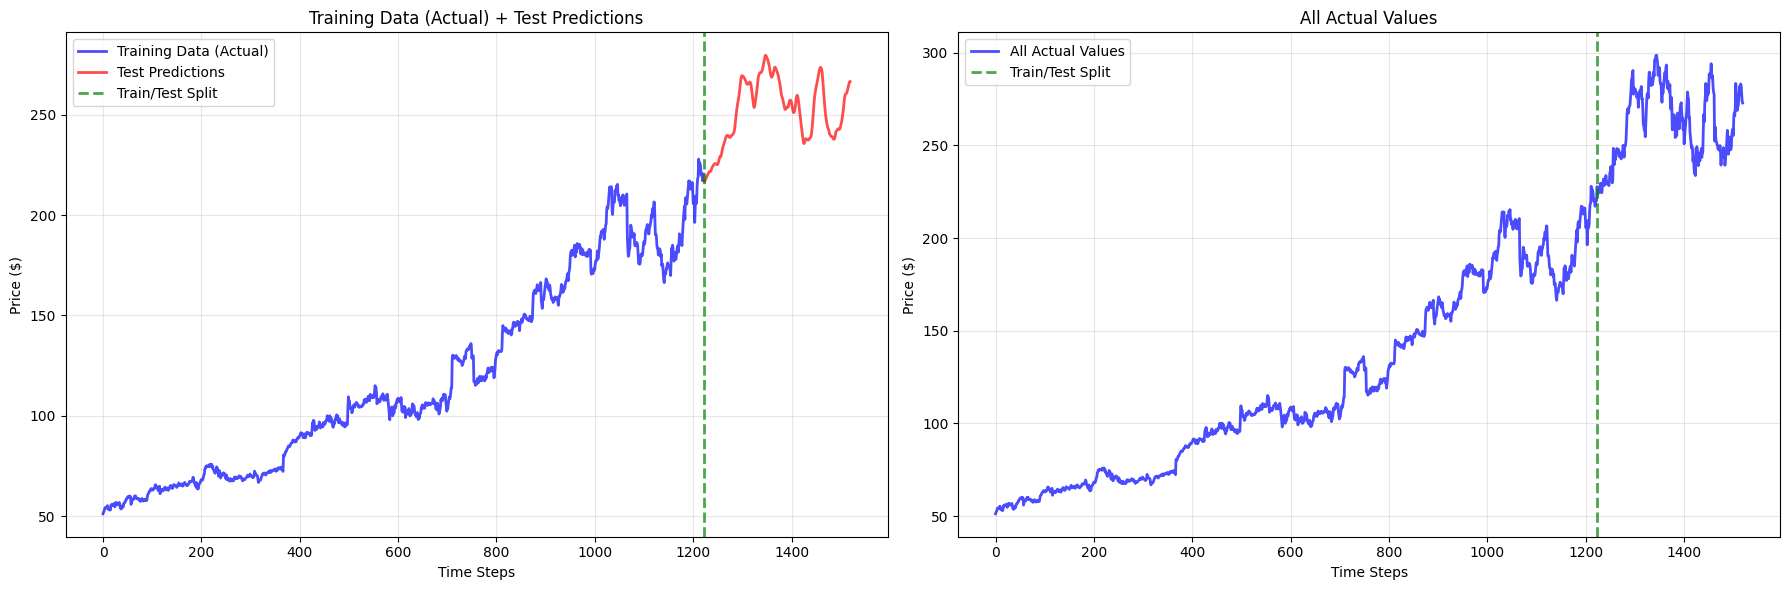

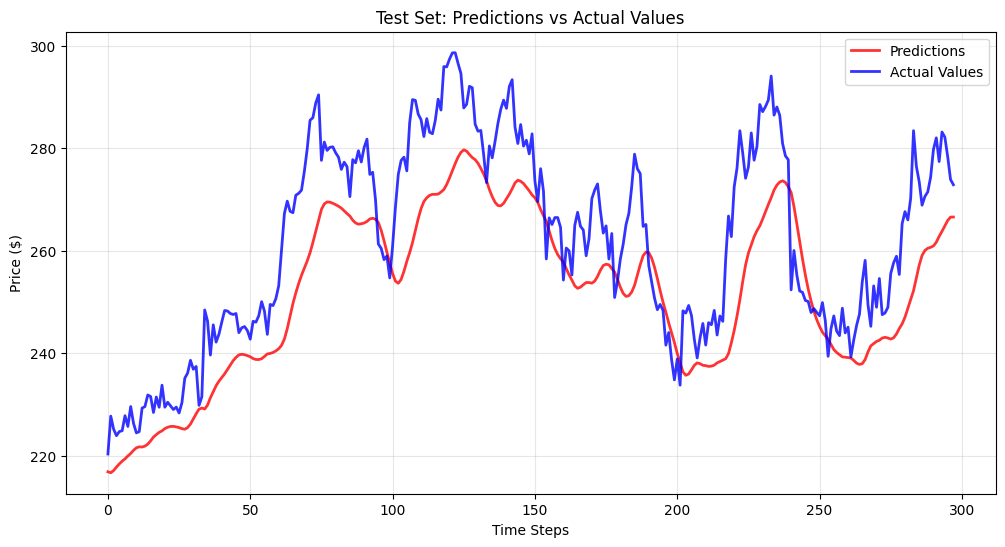


Metryki na zbiorze testowym:
MAE: $11.05
RMSE: $13.06
R²: 0.5449


In [29]:
predictions_array = np.concatenate(predictions, axis=0)
values_array = np.concatenate(values, axis=0)

predictions_original = scaler.inverse_transform(predictions_array)
values_original = scaler.inverse_transform(values_array)

all_values = df_dpz['DPZ'].values

train_size = len(X_train)
val_size = len(X_val)
test_start_idx = sequence_length + train_size + val_size

train_values = all_values[:test_start_idx]

print(f"Predictions shape: {predictions_array.shape}")
print(f"Values shape: {values_array.shape}")
print(f"Train values length: {len(train_values)}")
print(f"Test predictions length: {len(predictions_original)}")
print(f"Total timeline length: {len(train_values) + len(predictions_original)}")


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(range(len(train_values)), train_values, label='Training Data (Actual)',
             linewidth=2, color='blue', alpha=0.7)
axes[0].plot(range(len(train_values), len(train_values) + len(predictions_original)),
             predictions_original, label='Test Predictions', linewidth=2, color='red', alpha=0.7)
axes[0].axvline(x=len(train_values), color='green', linestyle='--', linewidth=2,
                label='Train/Test Split', alpha=0.7)
axes[0].legend()
axes[0].set_title('Training Data (Actual) + Test Predictions')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(all_values, linewidth=2, color='blue', alpha=0.7, label='All Actual Values')
axes[1].axvline(x=test_start_idx, color='green', linestyle='--', linewidth=2,
                label='Train/Test Split', alpha=0.7)
axes[1].legend()
axes[1].set_title('All Actual Values')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Price ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(predictions_original, label='Predictions', linewidth=2, alpha=0.8, color='red')
plt.plot(values_original, label='Actual Values', linewidth=2, alpha=0.8, color='blue')
plt.legend()
plt.title('Test Set: Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

# Metryki
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(values_original, predictions_original)
mae = mean_absolute_error(values_original, predictions_original)
rmse = np.sqrt(mse)
r2 = r2_score(values_original, predictions_original)

print(f"\n{'='*50}")
print(f"Metryki na zbiorze testowym:")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"{'='*50}")

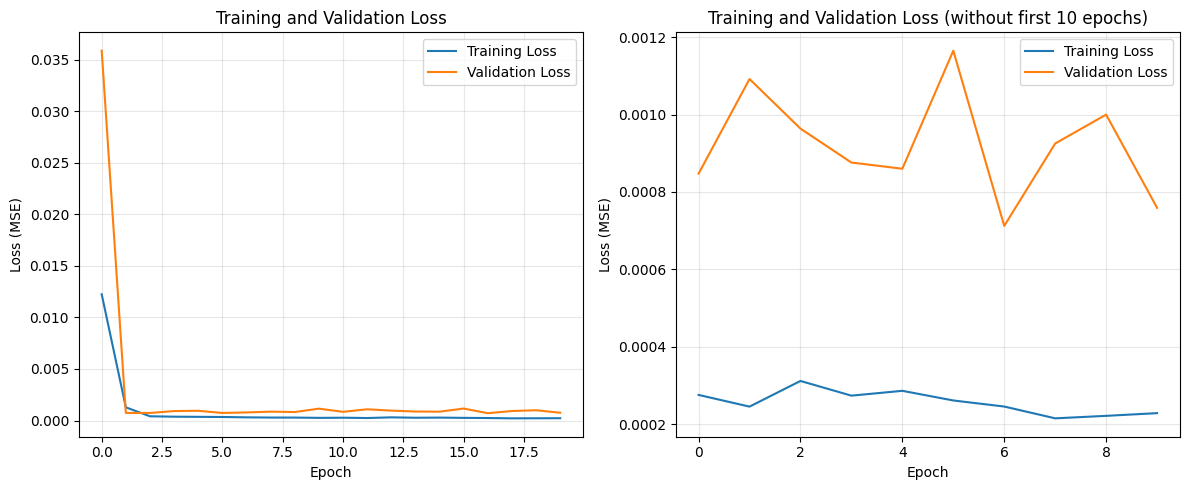

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(opt.train_losses, label='Training Loss')
plt.plot(opt.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(opt.train_losses[10:], label='Training Loss')
plt.plot(opt.val_losses[10:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss (without first 10 epochs)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()